In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from traceUtils import *
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import mixedlm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_validate, cross_val_score, GroupKFold
import sys
import os
from operator import itemgetter
import pickle
import json
import subprocess
from datetime import datetime
import glob
import sys
from numpy.linalg import LinAlgError

from drl_model_predictions import *

sys.path.append('../utils')
from plotting import *
from paths import *
from db import *
from protocols import *
from matio import loadmat

In [2]:
plt.style.use('paper_export')

In [33]:
# in the paper, the period from 2.5-3 seconds was used to focus on just the period immediately preceding
# reward delivery. However, the full Late Trace periods produces identical results. I have pre-computed
# licking using both and included them in the saved data, so either can be selected

lick_start = 2.5  # 2 would give Late Trace period
lick_end = 3

In [3]:
def fitp(formula, df, inds, do_print=False, re_formula=None):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        try:
            model = mixedlm(formula, df, groups='name', re_formula=re_formula)
            mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
        except LinAlgError:
            return 1
        
    if do_print:
        print(inds)
        print(mfit.summary())
    
    p = compute_lme_pval(mfit)[inds]
    if hasattr(inds, '__len__'):
        return p.astype(np.float64)
    elif p == '':
        return 1
    else:
        return float(p)

In [5]:
paths = get_db_info()

ret_df = pd.DataFrame()
excitations = [False, True]

for excitation in excitations:

    sql = 'SELECT session.name, protocol, exp_date, exp_time, genotype, raw_data_path, figure_path ' + \
        'FROM session LEFT JOIN mouse ON session.name=mouse.name WHERE has_opto=1 AND quality=3 AND exclude=0 ' + \
        'AND session.name != "AL85" AND session.name != "AL87" AND significance=1' 
    if excitation:
        sql += ' AND injection1 LIKE "%CoChR%"'
    else:
        sql += ' AND genotype LIKE "%GtACR%"'

    rets = execute_sql(sql, paths['db'])
    tmp_df = pd.DataFrame(rets, columns=rets[0].keys())
    tmp_df['excitation'] = excitation
    ret_df = pd.concat([ret_df, tmp_df], axis=0)

In [6]:
ret_df = ret_df.reset_index()
all_mice, unique_counts = np.unique(ret_df['name'], return_counts=True)
all_mice = sorted(all_mice)

color_set = list(mpl.cm.get_cmap('Set1').colors) + list(mpl.cm.get_cmap('Set2').colors) + \
            list(mpl.cm.get_cmap('Accent').colors) + list(mpl.cm.get_cmap('Dark2').colors)
                                                          
mouse_colors = {k: v for k, v in zip(all_mice, color_set)}
genotype_colors = ['#0A704E', '#FFA001']
# genotypes = np.unique(ret_df['genotype'])
genotypes = ['A2a-Cre', 'D1-Cre']

protocol = 'StimGradient'
colors, protocol_info, periods, kwargs = load_params(protocol)

satiety_cutoff = 10  # 10 straight trials with 0 licks
use_satiety_cutoff = False
n_trace_types = protocol_info['n_trace_types']

loc_labels = np.array(['No Stimulation', 'Ventral', 'Intermediate', 'Dorsal'], dtype='object')
use_loc_labels = np.array(['No Stimulation', 'Ventral', 'Dorsal'], dtype='object')
palette = {'No Stimulation': 'k', 'Ventral': '#BA55D3', 'Dorsal': '#0047AB'}
loc_palette = {k: v for k, v in zip(palette.keys(), palette.values()) if k != 'No Stimulation'}
geno_palette = {'A2a-Cre': '#BA55D3', 'D1-Cre': '#0047AB'}
opt_palette = {'Pessimistic': '#BA55D3', 'Optimistic': '#0047AB'}
fixed_tt = 1
variable_tt = 2

In [7]:
ninhib = np.sum(ret_df['genotype'].str.contains('GtACR1'))
print(ninhib)
print(len(ret_df) - ninhib)

92
96


In [8]:
print(np.sum(ret_df['genotype'].str.contains('D1-Cre')))
print(np.sum(ret_df['genotype'].str.contains('A2a-Cre')))

91
97


In [9]:
# mouse_rets = select_db(paths['db'], 'mouse', '*', 'surgery1 LIKE "%ibers%"', (), unique=False)
# mouse_df = pd.DataFrame(mouse_rets, columns=mouse_rets[0].keys())

In [10]:
save_path = os.path.join(paths['behavior_fig_roots'][1], 'compare_opto_lick_start_{:.1f}.p'.format(lick_start))
with open(save_path, 'rb') as f:
    df = pickle.load(f)

In [11]:
df

name                 genotype  excitation  exp_date  trial_type  \
0      MM14  D1-Cre +/- x GtACR1 +/-       False  20230627           0   
1      MM14  D1-Cre +/- x GtACR1 +/-       False  20230627           2   
2      MM14  D1-Cre +/- x GtACR1 +/-       False  20230627           1   
3      MM14  D1-Cre +/- x GtACR1 +/-       False  20230627           2   
4      MM14  D1-Cre +/- x GtACR1 +/-       False  20230627           2   
...     ...                      ...         ...       ...         ...   
56995  MM19              A2a-Cre +/-        True  20231004           1   
56996  MM19              A2a-Cre +/-        True  20231004           0   
56997  MM19              A2a-Cre +/-        True  20231004           0   
56998  MM19              A2a-Cre +/-        True  20231004           2   
56999  MM19              A2a-Cre +/-        True  20231004           1   

       stim_trial  stim_loc      loc_labels  licks  trial_num  next_licks  \
0               0         0  No Stimulation    6.0          0         2.0   
1               0         0  No Stimulation    2.0          1        14.0   
2               0         0  No Stimulation   14.0          2        10.0   
3               0         0  No Stimulation   10.0          3         0.0   
4               1         1         Ventral    0.0          4         0.0   
...           ...       ...             ...    ...        ...         ...   
56995           1         1         Ventral    0.0        314         0.0   
56996           1         3          Dorsal    0.0        315         0.0   
56997           0         0  No Stimulation    0.0        316         0.0   
56998           1         3          Dorsal    0.0        317         0.0   
56999           0         0  No Stimulation    0.0        318         NaN   

       next_stim_loc  next_trial_type  
0                0.0              2.0  
1                0.0              1.0  
2                0.0              2.0  
3                1.0              2.0  
4                0.0              1.0  
...              ...              ...  
56995            3.0              0.0  
56996            0.0              0.0  
56997            3.0              2.0  
56998            0.0              1.0  
56999            NaN              NaN  

[57000 rows x 13 columns]

In [12]:
# drop intermediate from df
df['Distribution'] =  np.array(protocol_info['trace_type_names'], dtype='object')[df['trial_type']]
df = df.drop(labels=np.flatnonzero(df['loc_labels'] == 'Intermediate'))

In [13]:
session_avg_df = df.groupby(['name', 'genotype', 'excitation', 'exp_date', 'trial_type', 'Distribution', 'stim_trial', 'stim_loc', 'loc_labels']).mean().reset_index()
session_avg_df['geno'] = session_avg_df['genotype'].str.replace(r'\s*\+/-\s*(?:x\s+GtACR1\s*\+/-\s*)?', '', regex=True)
mouse_avg_df = session_avg_df.groupby(['name', 'genotype', 'geno', 'excitation', 'trial_type', 'Distribution', 'stim_trial', 'stim_loc', 'loc_labels']).mean().reset_index()

## ED Fig. 11n

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight

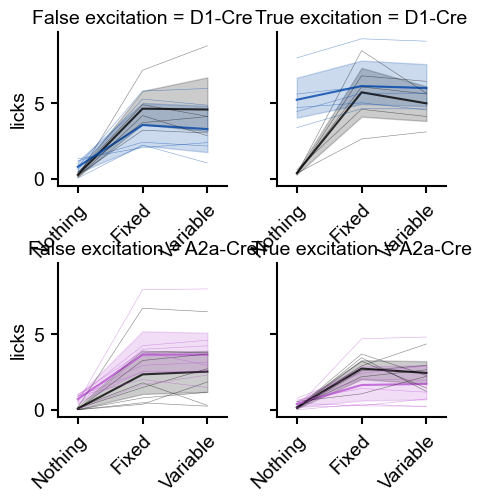

In [14]:
# plot all data, averaged across mice
tmp_df = mouse_avg_df[mouse_avg_df['loc_labels'] != 'Dorsal']
tmp_df['geno_loc_labels'] = tmp_df['geno'] + '_' + tmp_df['loc_labels']
tmp_geno_palette = {k + '_Ventral': v for k, v in geno_palette.items()}
tmp_geno_palette['D1-Cre_No Stimulation'] = 'k'
tmp_geno_palette['A2a-Cre_No Stimulation'] = 'k'

g = sns.FacetGrid(data=tmp_df, row='geno', 
                  col='excitation', row_order=['D1-Cre', 'A2a-Cre'],
                  aspect=1, height=2.5, sharex=False, gridspec_kws={'wspace': 0.3, 'hspace': 0.5})

g.map_dataframe(sns.lineplot, x='trial_type', y='licks', hue='geno_loc_labels', estimator='mean', 
                alpha=0.8, style=None, palette=tmp_geno_palette)  #lw=1, errorbar=None,
g.map_dataframe(sns.lineplot, x='trial_type', y='licks', hue='geno_loc_labels', size='excitation', 
                units='name', sizes=[.4], alpha=0.5, estimator=None, palette=tmp_geno_palette).set_titles(
    "{col_name} excitation = {row_name}")  #lw=1, errorbar=None,

g.set(xticks=np.arange(protocol_info['n_trace_types']))
g.set_xticklabels(protocol_info['trace_type_names'], rotation=45, ha='right', rotation_mode='anchor')
g.set(xlim=(-0.3, 2.3))
g.set_xlabels('')
# g.add_legend()

fname = f'figs/raw_opto_data_by_geno_and_excitation'
plt.savefig(fname + '.pdf', bbox_inches='tight')

In [16]:
session_avg_df_rel_nostim = session_avg_df.copy()
nostim_licks = np.repeat(session_avg_df.loc[session_avg_df['loc_labels'] == 'No Stimulation', 'licks'], len(use_loc_labels)).values
session_avg_df_rel_nostim['licks'] -= nostim_licks
session_avg_df_rel_nostim = session_avg_df_rel_nostim[session_avg_df_rel_nostim['loc_labels'] != 'No Stimulation']
# session_avg_df_rel_nostim

In [17]:
# compute all kinds of statistics on the licking
dummy_val = True

trim_loc_labels = use_loc_labels[1:]
genops = {e: {l: [] for l in trim_loc_labels} for e in excitations}
tt_genops = {e: {l: [] for l in trim_loc_labels} for e in excitations}
locps = {e: {g: [] for g in genotypes} for e in excitations}
tt_locps = {e: {g: [] for g in genotypes} for e in excitations}
geno_locps = {e: {dummy_val: []} for e in excitations}
tt_geno_locps = {e: {dummy_val: []} for e in excitations}
ttps = {e: {g: {l: [] for l in trim_loc_labels} for g in genotypes} for e in excitations}
intps = {e: {g: {l: [] for l in trim_loc_labels} for g in genotypes} for e in excitations}

for excitation in excitations:
    
    excit_df = session_avg_df_rel_nostim[session_avg_df_rel_nostim['excitation'] == excitation]
    geno_locps[excitation][dummy_val] = fitp('licks ~ C(geno) * C(loc_labels) * C(trial_type)', excit_df,
                                             protocol_info['n_trace_types'] + len(genotypes) + len(trim_loc_labels) - 2)
#     print(excitation, geno_locps[excitation][dummy_val], 'geno_locps (comparison to Nothing)')
    
    for tt in range(protocol_info['n_trace_types']):
        p = fitp('licks ~ C(geno) * C(loc_labels)', excit_df[excit_df['trial_type'] == tt],
                 protocol_info['n_trace_types'])
        tt_geno_locps[excitation][dummy_val].append(p)
    
    for stim_loc in trim_loc_labels:
        
        loc_df = excit_df[excit_df['loc_labels'] == stim_loc]
        loc_df['neg_tt'] = -loc_df['trial_type']  # to see differences relative to Variable
        
        print(f'licks ~ C(geno) * C(trial_type) restricted to {stim_loc} {excitation}')
        genops[excitation][stim_loc] = fitp('licks ~ C(geno) * C(trial_type)', loc_df, 1, do_print=True)
        fitp('licks ~ C(geno) * C(neg_tt)', loc_df, 1, do_print=True)
        
        for tt in range(protocol_info['n_trace_types']):
            print(f'licks ~ C(geno) restricted to {stim_loc} and {tt} {excitation}')
            p = fitp('licks ~ C(geno)', loc_df[loc_df['trial_type'] == tt], 1, do_print=True)
#             print(excitation, stim_loc, tt, p, 'tt_genops (comparison to Nothing)')
            tt_genops[excitation][stim_loc].append(p)
    
    for genotype in genotypes:
        
        geno_df = excit_df[excit_df['geno'] == genotype]
        locps[excitation][genotype] = fitp('licks ~ C(loc_labels) * C(trial_type)', geno_df, 1)
        
        for tt in range(protocol_info['n_trace_types']):
            
            p = fitp('licks ~ C(loc_labels)', geno_df[geno_df['trial_type'] == tt], 1)
#             print(excitation, stim_loc, tt, p, 'tt_genops (comparison to Nothing)')
            tt_locps[excitation][genotype].append(p)
    
        for stim_loc in trim_loc_labels:
            
            geno_loc_df = geno_df[geno_df['loc_labels'] == stim_loc]
            geno_loc_df['neg_tt'] = -geno_loc_df['trial_type']  # to see differences relative to Variable
            print(f'licks ~ C(trial_type) restricted to {stim_loc} and {genotype} {excitation}')
            
            ttps[excitation][genotype][stim_loc] = fitp(
                'licks ~ C(trial_type)', geno_loc_df, np.arange(1, protocol_info['n_trace_types']), do_print=True)
            # print(excitation, genotype, stim_loc, ttps[excitation][genotype][stim_loc], 'ttps (comparison to Nothing)')

            # ttps[excitation][genotype][stim_loc] = 
            fitp('licks ~ C(neg_tt)', geno_loc_df, np.arange(1, protocol_info['n_trace_types']), do_print=True)
            # print(excitation, genotype, stim_loc, ttps[excitation][genotype][stim_loc], 'ttps (comparison to Variable)')

            for tt in range(protocol_info['n_trace_types']):
                print(f'licks ~ 1 restricted to {stim_loc} and {genotype} and {tt} {excitation}')
                p = fitp('licks ~ 1', geno_loc_df[geno_loc_df['trial_type'] == tt], 0, do_print=True)
#                 print(excitation, genotype, stim_loc, tt, p, 'tt_inpts (Intercept; comparison to 0)')
                intps[excitation][genotype][stim_loc].append(p)

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


licks ~ C(geno) * C(trial_type) restricted to Ventral False
1
                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                licks    
No. Observations:                276                    Method:                            REML     
No. Groups:                      13                     Scale:                             2.1729   
Min. group size:                 3                      Log-Likelihood:                    -509.4441
Max. group size:                 33                     Converged:                         Yes      
Mean group size:                 21.2                                                               
----------------------------------------------------------------------------------------------------
                                       Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               licks    
No. Observations:               276                   Method:                           REML     
No. Groups:                     13                    Scale:                            2.5128   
Min. group size:                3                     Log-Likelihood:                   -529.0304
Max. group size:                33                    Converged:                        Yes      
Mean group size:                21.2                                                             
-------------------------------------------------------------------------------------------------
                                    Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------------------------------
Intercept                          1.555e+00 3.9

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


licks ~ C(trial_type) restricted to Ventral and A2a-Cre False
[1 2]
                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         licks    
No. Observations:         144             Method:                     REML     
No. Groups:               8               Scale:                      2.0096   
Min. group size:          3               Log-Likelihood:             -259.9358
Max. group size:          30              Converged:                  Yes      
Mean group size:          18.0                                                 
-------------------------------------------------------------------------------
                     Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
-------------------------------------------------------------------------------
Intercept          6.276e-01 3.124e-01 2.009e+00 4.453e-02  1.535e-02 1.240e+00
C(trial_type)[T.1] 4.967e-01 2.894e-01 1.717e+00 8.604e-02 -7.040e-02 1.0

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     licks    
No. Observations:       48          Method:                 REML     
No. Groups:             8           Scale:                  3.1141   
Min. group size:        1           Log-Likelihood:         -101.1411
Max. group size:        10          Converged:              Yes      
Mean group size:        6.0                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.651e+00 6.576e-01 2.511e+00 1.204e-02 3.624e-01 2.940e+00
name Var  2.702e+00 1.131e+00                                        

licks ~ C(trial_type) restricted to Ventral and D1-Cre False
[1 2]
                      Mixed Linear Model Regression Results
Model:                     MixedLM          De

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2711: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/traceUtils.py:180: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:mfit.k_fe, 1] = np.sqrt(np.diag(mfit.cov_params()[0:mfit.k_fe]))
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher

0
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: licks   
No. Observations: 44      Method:             REML    
No. Groups:       5       Scale:              0.5102  
Min. group size:  2       Log-Likelihood:     -48.4362
Max. group size:  11      Converged:          Yes     
Mean group size:  8.8                                 
------------------------------------------------------
                Coef.   Std.Err. z P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     6.617e-01                               
name Var      5.813e-11                               

licks ~ 1 restricted to Ventral and D1-Cre and 1 False
0
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       licks   
No. Observations:       44            Method:                   REML    
No. Groups:             5             Scale:                    1.9249  
Min. group size

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


licks ~ C(geno) * C(trial_type) restricted to Ventral True
1
                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                licks    
No. Observations:                288                    Method:                            REML     
No. Groups:                      12                     Scale:                             4.0363   
Min. group size:                 3                      Log-Likelihood:                    -619.5086
Max. group size:                 33                     Converged:                         Yes      
Mean group size:                 24.0                                                               
----------------------------------------------------------------------------------------------------
                                       Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
--------------------------------------------------------------

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
                             Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              licks    
No. Observations:                288                  Method:                          REML     
No. Groups:                      12                   Scale:                           3.0067   
Min. group size:                 3                    Log-Likelihood:                  -574.1287
Max. group size:                 33                   Converged:                       Yes      
Mean group size:                 24.0                                                           
------------------------------------------------------------------------------------------------
                                    Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------------------------------
Intercept                          1.284e+00 3.640e-01  3.

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


licks ~ C(trial_type) restricted to Ventral and A2a-Cre True
[1 2]
                      Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          licks    
No. Observations:          147              Method:                      REML     
No. Groups:                7                Scale:                       4.6034   
Min. group size:           3                Log-Likelihood:              -324.7918
Max. group size:           33               Converged:                   Yes      
Mean group size:           21.0                                                   
----------------------------------------------------------------------------------
                     Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
----------------------------------------------------------------------------------
Intercept           1.556e-01 4.975e-01  3.127e-01 7.545e-01 -8.196e-01  1.131e+00
C(trial_type)[T.1] -1.179e+00 4.335e-01 -2.

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


licks ~ C(trial_type) restricted to Dorsal and A2a-Cre True
[1 2]
                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         licks    
No. Observations:         147             Method:                     REML     
No. Groups:               7               Scale:                      2.7143   
Min. group size:          3               Log-Likelihood:             -286.7348
Max. group size:          33              Converged:                  Yes      
Mean group size:          21.0                                                 
-------------------------------------------------------------------------------
                     Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
-------------------------------------------------------------------------------
Intercept          8.882e-01 3.830e-01 2.319e+00 2.037e-02  1.376e-01 1.639e+00
C(trial_type)[T.1] 2.780e-01 3.328e-01 8.351e-01 4.037e-01 -3.744e-01 9.303

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      licks   
No. Observations:      47           Method:                  REML    
No. Groups:            5            Scale:                   2.6503  
Min. group size:       9            Log-Likelihood:          -94.3547
Max. group size:       10           Converged:               Yes     
Mean group size:       9.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.841e+00 7.776e-01 6.226e+00 4.793e-10 3.317e+00 6.365e+00
name Var  2.740e+00 1.375e+00                                        

licks ~ 1 restricted to Ventral and D1-Cre and 1 True
0
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      l

In [18]:
for excitation in excitations:
    print(excitation)
    excit_df = session_avg_df_rel_nostim[session_avg_df_rel_nostim['excitation'] == excitation]
    for stim_loc in trim_loc_labels:
        print(stim_loc)
        rewloc_df = excit_df[np.logical_and(excit_df['loc_labels'] == stim_loc, excit_df['trial_type'] != 0)]
        fitp('licks ~ C(geno) * C(trial_type)', rewloc_df, 1, True, re_formula='~trial_type')
    for geno in genotypes:
        print(geno)
        rewgeno_df = excit_df[np.logical_and(excit_df['geno'] == geno, excit_df['trial_type'] != 0)]
        fitp('licks ~ C(stim_loc) * C(trial_type)', rewgeno_df, 1, True, re_formula='~trial_type')

False
Ventral
1
                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                licks    
No. Observations:                184                    Method:                            REML     
No. Groups:                      13                     Scale:                             2.4876   
Min. group size:                 2                      Log-Likelihood:                    -357.0158
Max. group size:                 22                     Converged:                         Yes      
Mean group size:                 14.2                                                               
----------------------------------------------------------------------------------------------------
                                       Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
----------------------------------------------------------------------------------------------------
Interc

In [19]:
# compute within-session differences between fixed and variable at each stim location
within_sess_diffs = session_avg_df.copy().sort_values(['name', 'exp_date', 'stim_loc'])
fixed_licking = np.repeat(within_sess_diffs[within_sess_diffs['trial_type'] == fixed_tt]['licks'].values, protocol_info['n_trace_types'])
within_sess_diffs['licks'] = within_sess_diffs['licks'] - fixed_licking
within_sess_diffs

name                  genotype  excitation  exp_date  trial_type  \
0     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           0   
3     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           1   
6     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           2   
1     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           0   
4     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           1   
...    ...                       ...         ...       ...         ...   
1687  MM19               A2a-Cre +/-        True  20231013           1   
1690  MM19               A2a-Cre +/-        True  20231013           2   
1685  MM19               A2a-Cre +/-        True  20231013           0   
1688  MM19               A2a-Cre +/-        True  20231013           1   
1691  MM19               A2a-Cre +/-        True  20231013           2   

     Distribution  stim_trial  stim_loc      loc_labels     licks   trial_num  \
0         Nothing           0         0  No Stimulation -0.431373  147.290909   
3           Fixed           0         0  No Stimulation  0.000000  144.607843   
6        Variable           0         0  No Stimulation -0.145658  140.946429   
1         Nothing           1         1         Ventral -1.509524  151.619048   
4           Fixed           1         1         Ventral  0.000000  114.000000   
...           ...         ...       ...             ...       ...         ...   
1687        Fixed           1         1         Ventral  0.000000  160.909091   
1690     Variable           1         1         Ventral  0.181818  129.272727   
1685      Nothing           1         3          Dorsal -2.739048  177.476190   
1688        Fixed           1         3          Dorsal  0.000000  160.880000   
1691     Variable           1         3          Dorsal  0.110769  149.769231   

      next_licks  next_stim_loc  next_trial_type     geno  
0       1.709091       0.709091         0.872727  A2a-Cre  
3       1.760000       0.720000         0.980000  A2a-Cre  
6       2.107143       1.178571         1.089286  A2a-Cre  
1       1.047619       1.238095         1.095238  A2a-Cre  
4       1.600000       0.400000         0.700000  A2a-Cre  
...          ...            ...              ...      ...  
1687    4.727273       0.818182         1.181818  A2a-Cre  
1690    2.909091       0.772727         1.136364  A2a-Cre  
1685    1.809524       1.238095         0.761905  A2a-Cre  
1688    4.240000       0.720000         1.080000  A2a-Cre  
1691    3.769231       1.115385         1.076923  A2a-Cre  

[1692 rows x 15 columns]

In [20]:
variable_diffs = within_sess_diffs[within_sess_diffs['trial_type'] == variable_tt]
variable_diffs_norm_nostim = variable_diffs.copy()
norm_nostim = np.repeat(variable_diffs_norm_nostim.loc[variable_diffs_norm_nostim['loc_labels'] == 'No Stimulation', 'licks'], len(use_loc_labels))
variable_diffs_norm_nostim['licks'] = variable_diffs_norm_nostim['licks'] - norm_nostim.values
variable_diffs_norm_nostim

name                  genotype  excitation  exp_date  trial_type  \
6     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           2   
7     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           2   
8     AL91  A2a-Cre +/- x GtACR1 +/-       False  20230923           2   
15    AL91  A2a-Cre +/- x GtACR1 +/-       False  20230928           2   
16    AL91  A2a-Cre +/- x GtACR1 +/-       False  20230928           2   
...    ...                       ...         ...       ...         ...   
1681  MM19               A2a-Cre +/-        True  20231012           2   
1682  MM19               A2a-Cre +/-        True  20231012           2   
1689  MM19               A2a-Cre +/-        True  20231013           2   
1690  MM19               A2a-Cre +/-        True  20231013           2   
1691  MM19               A2a-Cre +/-        True  20231013           2   

     Distribution  stim_trial  stim_loc      loc_labels     licks   trial_num  \
6        Variable           0         0  No Stimulation  0.000000  140.946429   
7        Variable           1         1         Ventral -0.594342  135.480000   
8        Variable           1         3          Dorsal  1.131373  143.200000   
15       Variable           0         0  No Stimulation  0.000000  143.333333   
16       Variable           1         1         Ventral  0.249246  134.958333   
...           ...         ...       ...             ...       ...         ...   
1681     Variable           1         1         Ventral  0.373484  139.920000   
1682     Variable           1         3          Dorsal  1.085908  157.333333   
1689     Variable           0         0  No Stimulation  0.000000  149.211538   
1690     Variable           1         1         Ventral  0.157870  129.272727   
1691     Variable           1         3          Dorsal  0.086821  149.769231   

      next_licks  next_stim_loc  next_trial_type     geno  
6       2.107143       1.178571         1.089286  A2a-Cre  
7       1.040000       0.760000         0.880000  A2a-Cre  
8       0.700000       0.700000         1.400000  A2a-Cre  
15      0.509804       0.882353         0.960784  A2a-Cre  
16      1.083333       0.958333         1.166667  A2a-Cre  
...          ...            ...              ...      ...  
1681    4.320000       0.840000         0.840000  A2a-Cre  
1682    4.333333       0.875000         1.041667  A2a-Cre  
1689    3.384615       0.769231         0.903846  A2a-Cre  
1690    2.909091       0.772727         1.136364  A2a-Cre  
1691    3.769231       1.115385         1.076923  A2a-Cre  

[564 rows x 15 columns]

# Formal model comparisons

# Fig. 5c-d, ED Fig. 7a-h, k-m, 11a-i,l-m

4.0
[-2.  2.  6. 10.]
1.0
[0. 4. 8.]
[array([1., 0., 0.]), array([0., 1., 0.]), array([0.5, 0. , 0.5])]
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[0]
[2]
[[0.17391304 0.4137931  0.57142857 0.68292683 0.76595745 0.83018868
  0.88135593 0.92307692 0.95774648 0.98701299]
 [0.01298701 0.04225352 0.07692308 0.11864407 0.16981132 0.23404255
  0.31707317 0.42857143 0.5862069  0.82608696]]
Reflected Expectile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)
[[  0.         131.24338625 157.93433296]
 [131.24338625   0.          26.69094671]
 [157.93433296  26.69094671   0.        ]]
[[ 0.         61.87496745 35.03950708]
 [61.87496745  0.         96.91447453]
 [35.03950708 96.91447453  0.        ]]
(2, 1000)
(10, 2) (10,)
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Expectile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)
[[  0.         134.19005473 158.73868751]
 [134.19005473   0.          24.54863277]
 [158.73868751  24.54863277   0.        ]]
[[  0.          64.85877699  38.79814777]
 [ 64.85877699   0.         103.65692475]
 [ 38.79814777 103.65692475   0.        ]]
(2, 1000)
(10, 2) (10,)
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Quantile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)
[[  0.          90.33787293 202.08966433]
 [ 90.33787293   0.         111.7517914 ]
 [202.08966433 111.7517914    0.        ]]
[[  0.         125.05552698   8.53274419]
 [125.05552698   0.         116.52278279]
 [  8.53274419 116.52278279   0.        ]]
(2, 1000)
(10, 2) (10,)
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Reflected Quantile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)
[[  0.         103.92610061 205.1881179 ]
 [103.92610061   0.         101.26201728]
 [205.1881179  101.26201728   0.        ]]
[[  0.         120.40866677   1.04675667]
 [120.40866677   0.         121.45542344]
 [  1.04675667 121.45542344   0.        ]]
(2, 1000)
(10, 2) (10,)
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 3)
50
(1000, 150)
100 10 50 3
(1000, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Distributed AU
[0.05 0.05 0.15 0.15 0.25 0.25 0.35 0.35 0.45 0.45 0.55 0.55 0.65 0.65
 0.75 0.75 0.85 0.85 0.95 0.95]
(2000, 3)
50
(2000, 150)
100 20 50 3
(2000, 150)
[[  0.          83.32025871 725.01226368]
 [ 83.32025871   0.         641.69200497]
 [725.01226368 641.69200497   0.        ]]
[[  0.         315.38397216 128.8512104 ]
 [315.38397216   0.         186.53276176]
 [128.8512104  186.53276176   0.        ]]
(2, 2000)
(20, 2) (20,)
[0.05 0.05 0.15 0.15 0.25 0.25 0.35 0.35 0.45 0.45 0.55 0.55 0.65 0.65
 0.75 0.75 0.85 0.85 0.95 0.95]
(2000, 3)
50
(2000, 150)
100 20 50 3
(2000, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Partial Distributed AU
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 0.05 0.15 0.25 0.35
 0.45 0.55 0.65 0.75 0.85 0.95]
(2000, 3)
50
(2000, 150)
100 20 50 3
(2000, 150)
[[  0.         102.42739149 738.91585116]
 [102.42739149   0.         636.48845966]
 [738.91585116 636.48845966   0.        ]]
[[  0.         315.6432301  122.56233262]
 [315.6432301    0.         193.08089748]
 [122.56233262 193.08089748   0.        ]]
(2, 2000)
(20, 2) (20,)
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 0.05 0.15 0.25 0.35
 0.45 0.55 0.65 0.75 0.85 0.95]
(2000, 3)
50
(2000, 150)
100 20 50 3
(2000, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Actor Uncertainty (AU)
[0.5 0.5]
(200, 3)
50
(200, 150)
100 2 50 3
(200, 150)
[[  0.          43.17954254 307.68231869]
 [ 43.17954254   0.         264.50277615]
 [307.68231869 264.50277615   0.        ]]
[[  0.         129.89355144  50.24328856]
 [129.89355144   0.          79.65026288]
 [ 50.24328856  79.65026288   0.        ]]
(2, 200)
(2, 2) (2,)
[0.5 0.5]
(200, 3)
50
(200, 150)
100 2 50 3
(200, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Categorical
[0. 4. 8.]
(300, 3)
50
(300, 150)
100 3 50 3
(300, 150)
[[ 0.         15.19597796  3.21788126]
 [15.19597796  0.         11.9780967 ]
 [ 3.21788126 11.9780967   0.        ]]
[[0.         3.0952511  9.60142875]
 [3.0952511  0.         6.50617765]
 [9.60142875 6.50617765 0.        ]]
(2, 300)
(3, 2) (3,)
[0. 4. 8.]
(300, 3)
50
(300, 150)
100 3 50 3
(300, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Laplace
[0. 4. 8.]
(300, 3)
50
(300, 150)
100 3 50 3
(300, 150)
[[ 0.         11.63304693  5.70371086]
 [11.63304693  0.          5.92933607]
 [ 5.70371086  5.92933607  0.        ]]
[[0.         0.09675913 7.53160921]
 [0.09675913 0.         7.43485008]
 [7.53160921 7.43485008 0.        ]]
(2, 300)
(3, 2) (3,)
[0. 4. 8.]
(300, 3)
50
(300, 150)
100 3 50 3
(300, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Cumulative
[0. 4. 8.]
(300, 3)
50
(300, 150)
100 3 50 3
(300, 150)
[[ 0.         11.46634987  4.77679644]
 [11.46634987  0.          6.68955343]
 [ 4.77679644  6.68955343  0.        ]]
[[0.         0.84018599 7.97505151]
 [0.84018599 0.         7.13486553]
 [7.97505151 7.13486553 0.        ]]
(2, 300)
(3, 2) (3,)
[0. 4. 8.]
(300, 3)
50
(300, 150)
100 3 50 3
(300, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Moments
[0.5 0.5]
(200, 3)
50
(200, 150)
100 2 50 3
(200, 150)
[[  0.           2.88752526 175.92606806]
 [  2.88752526   0.         173.03854281]
 [175.92606806 173.03854281   0.        ]]
[[ 0.         90.06349484 43.91389503]
 [90.06349484  0.         46.14959981]
 [43.91389503 46.14959981  0.        ]]
(2, 200)
(2, 2) (2,)
[0.5 0.5]
(200, 3)
50
(200, 150)
100 2 50 3
(200, 150)


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


(1, 11, 2, 1) (1, 11, 2, 1) (1, 11, 2, 1)
2 1 1


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:714: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(4, 2))
meta NOT subset; don't know how to subset; dropped


Nothing
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0, 0.0]
[0.0, 0.0]
Fixed
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[3.0866666666666633, 3.7417460317460303]
[3.0866666666666633, 3.7417460317460303]
Variable
[0.40213338 1.20572322 2.00841178 2.81020057 3.61109111 4.4110849
 5.21018345 6.00838826 6.80570083 7.60212265]
[1.084854548538831, 4.57533011709871]
[1.084854548538831, 4.57533011709871]


meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/behavior_analysis/drl_model_predictions.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don

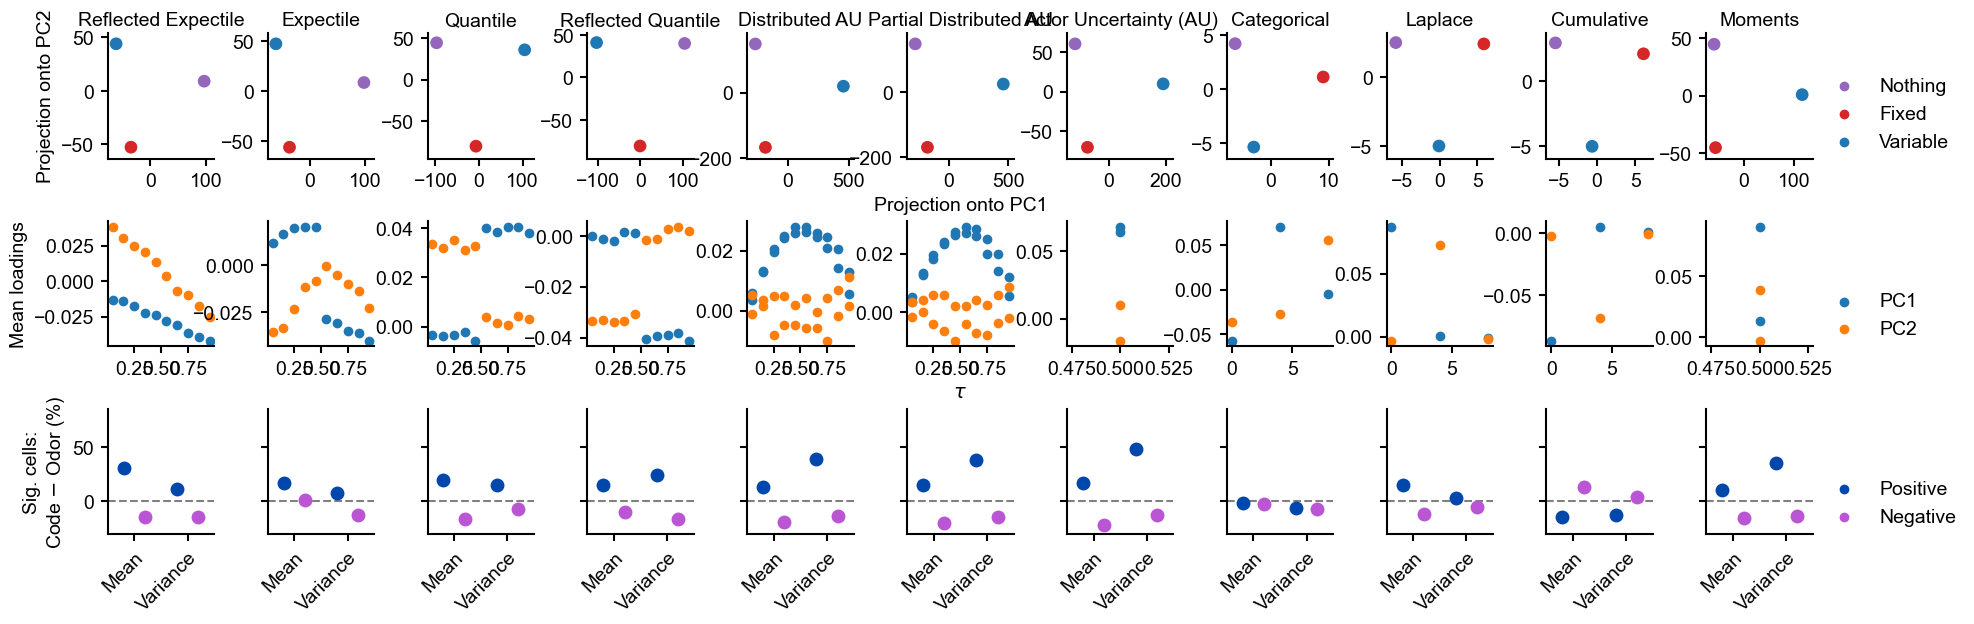

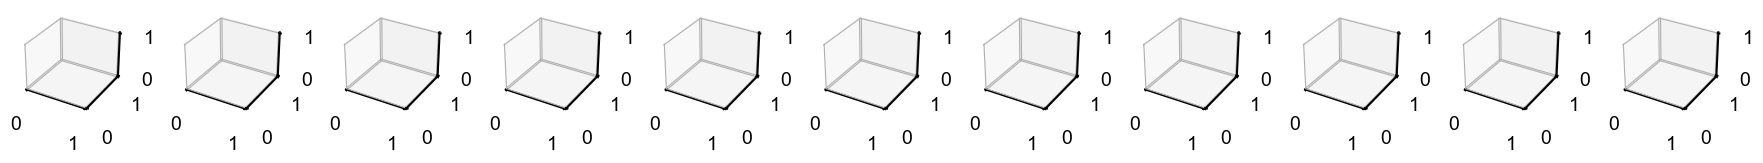

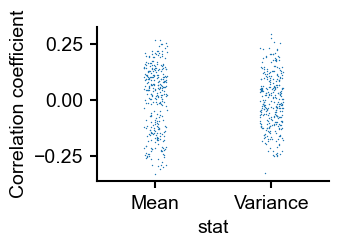

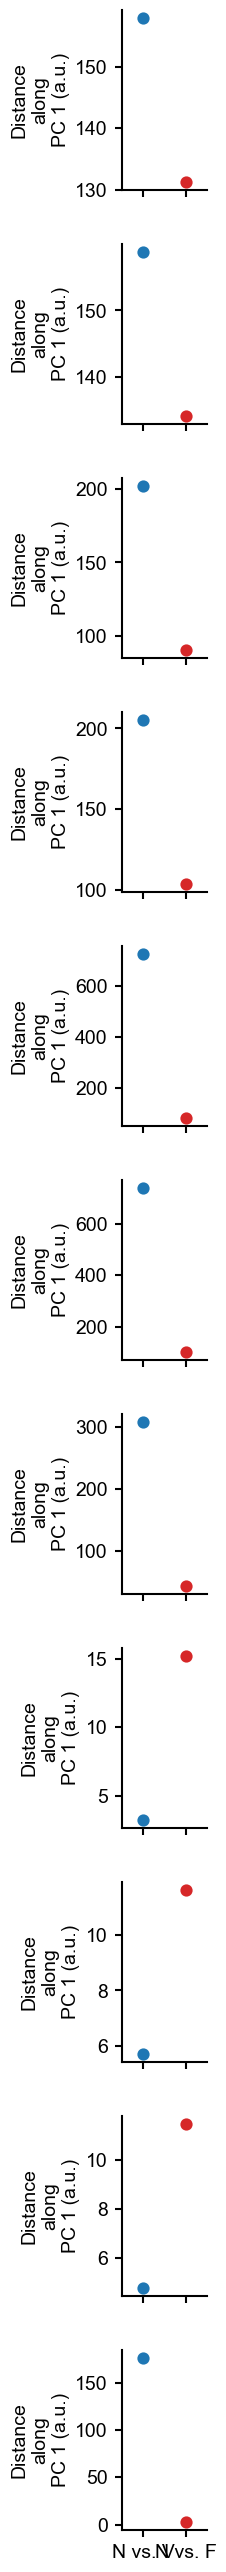

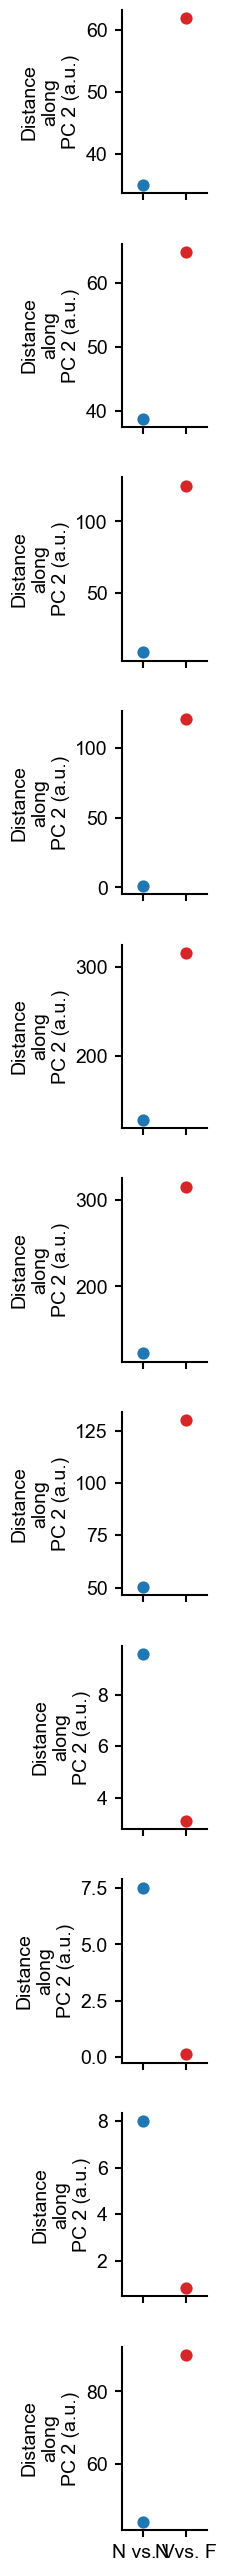

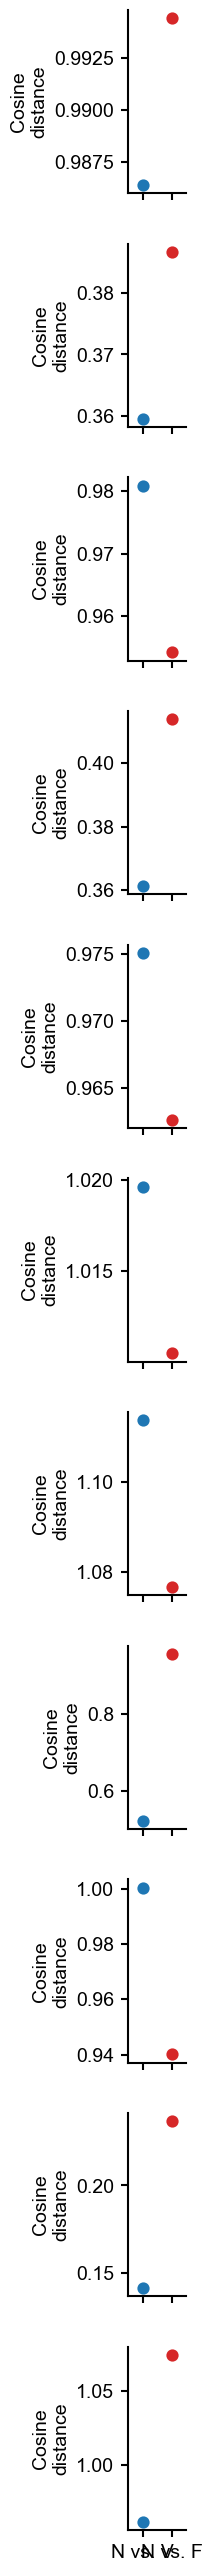

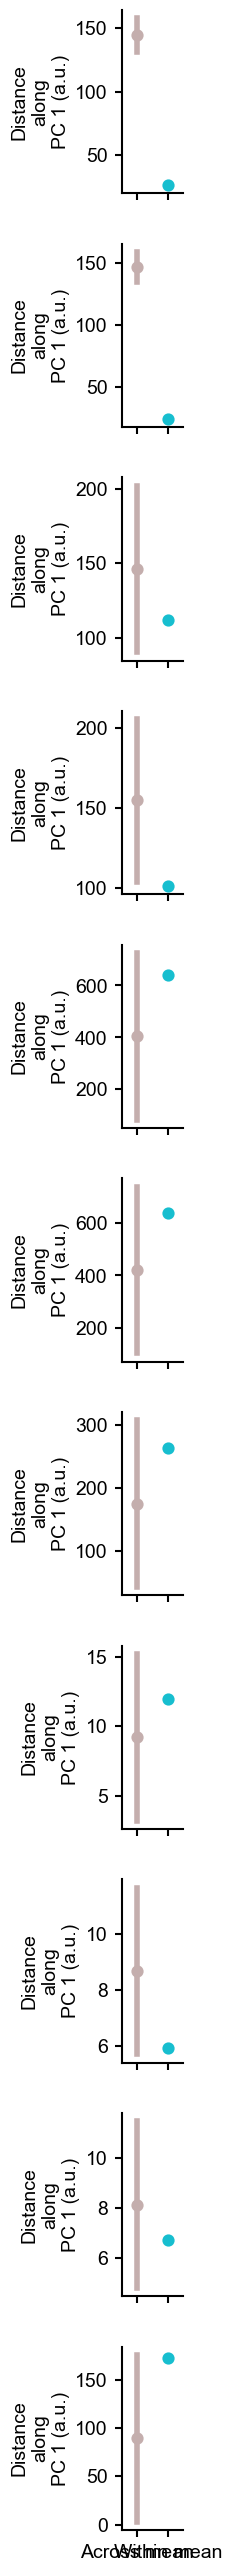

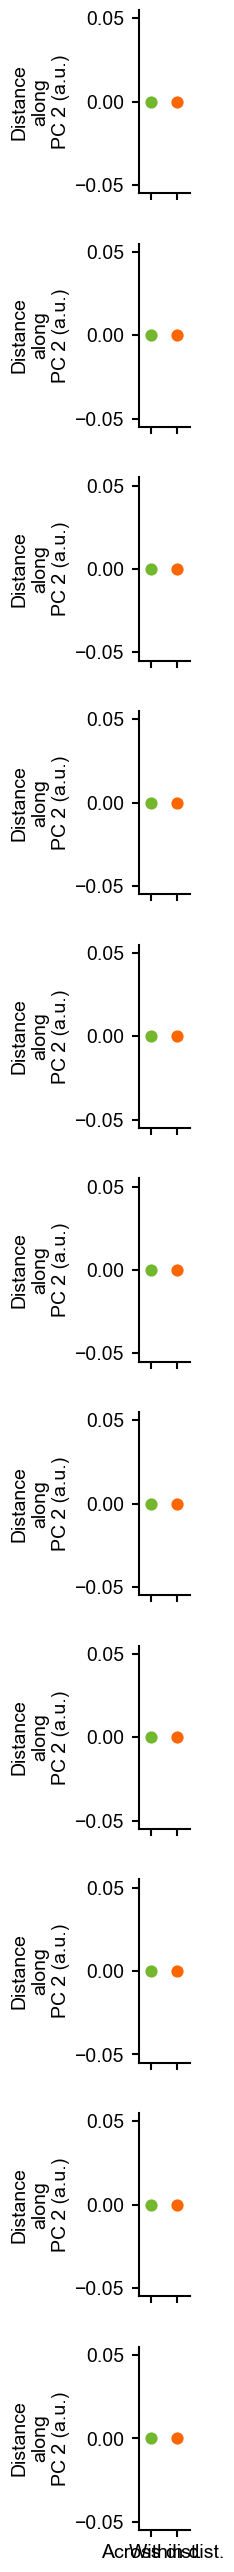

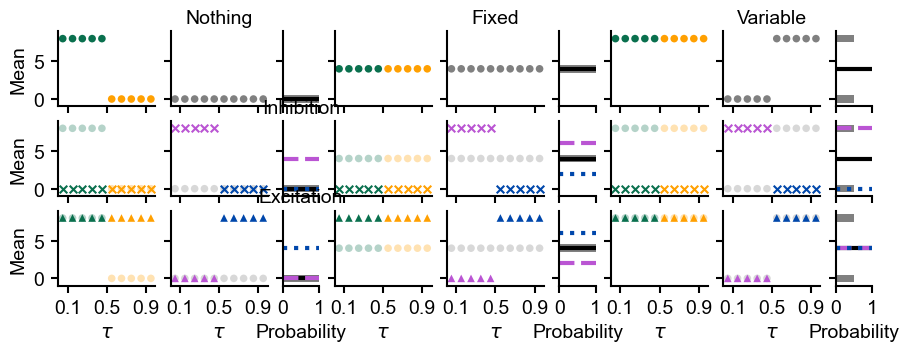

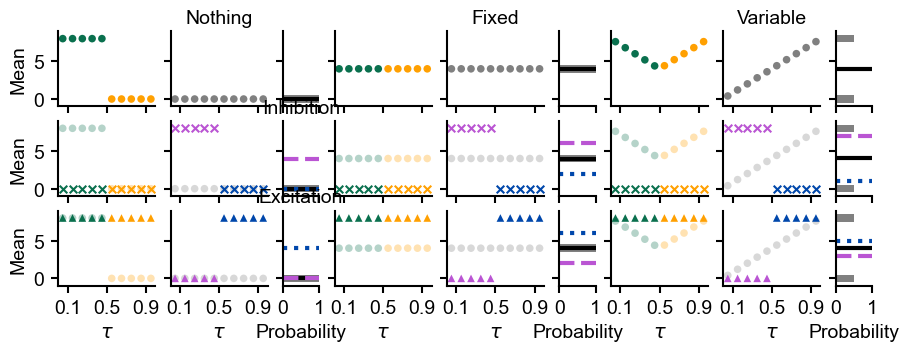

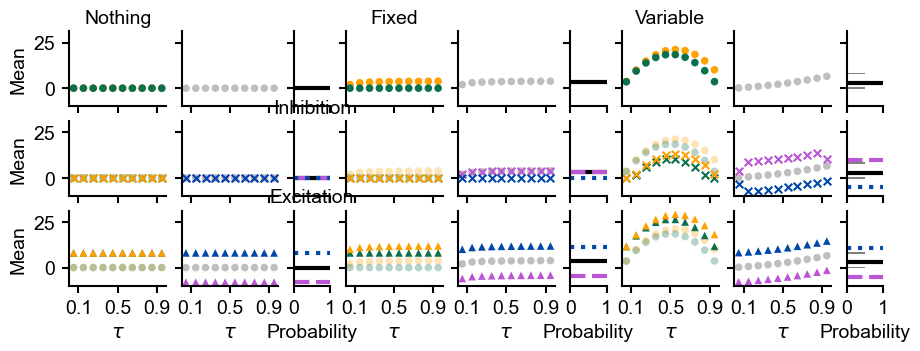

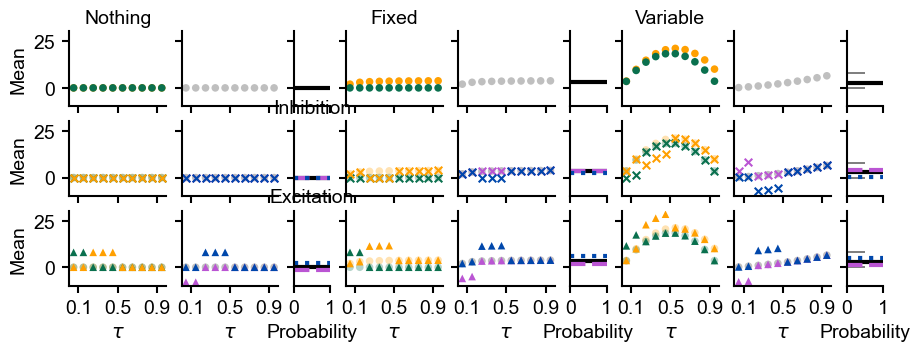

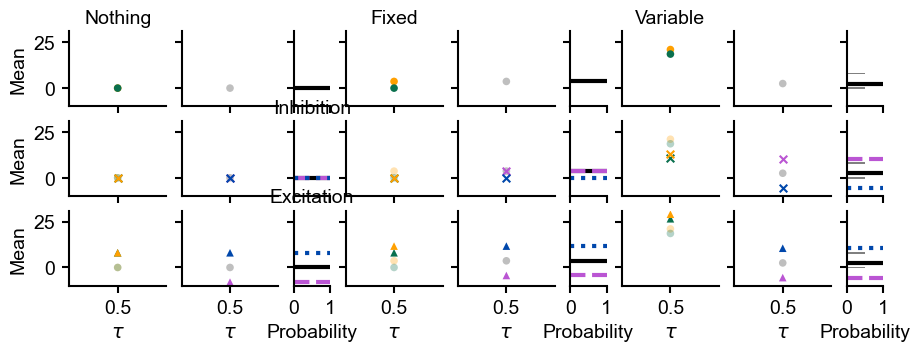

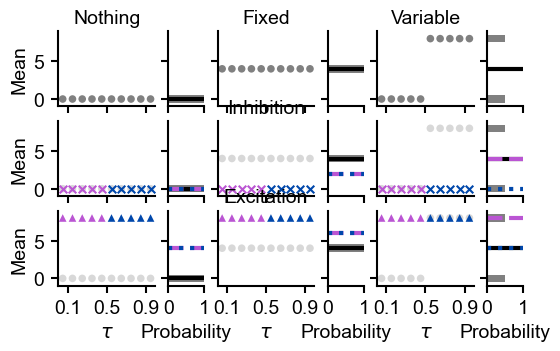

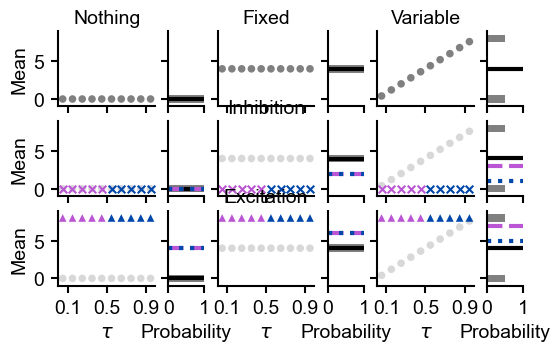

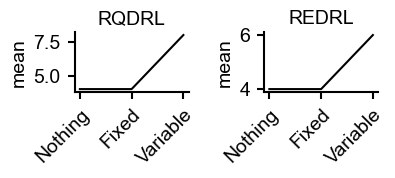

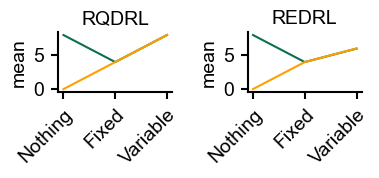

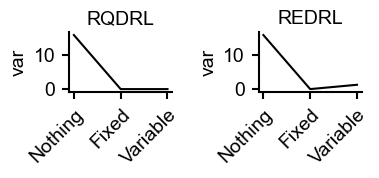

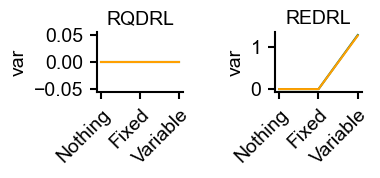

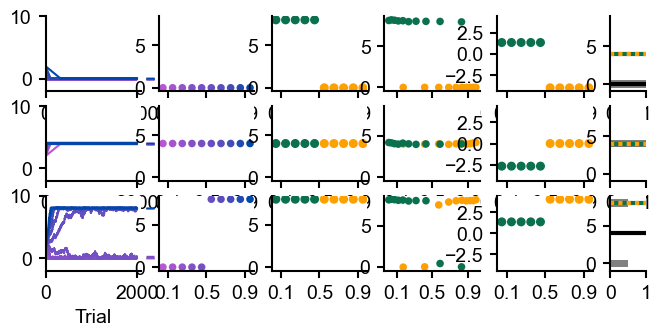

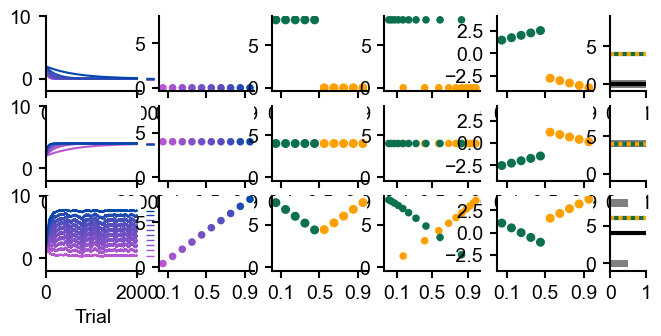

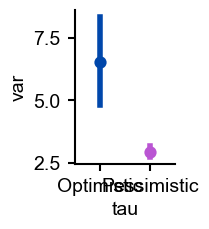

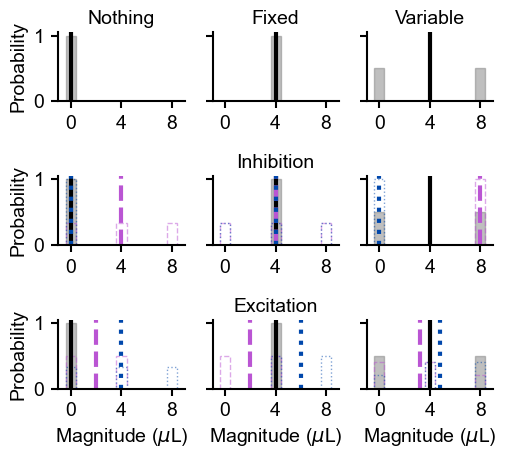

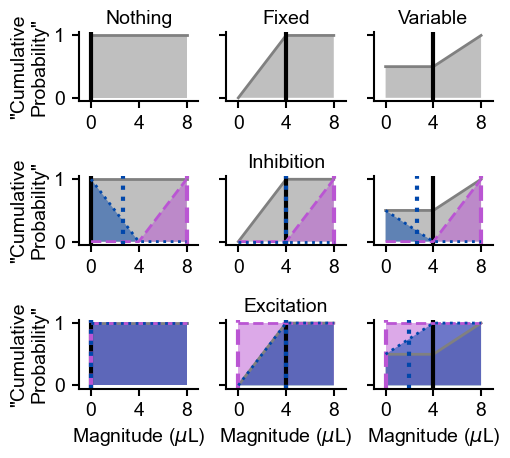

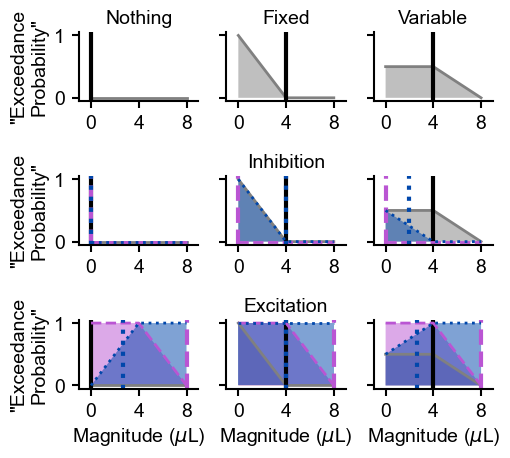

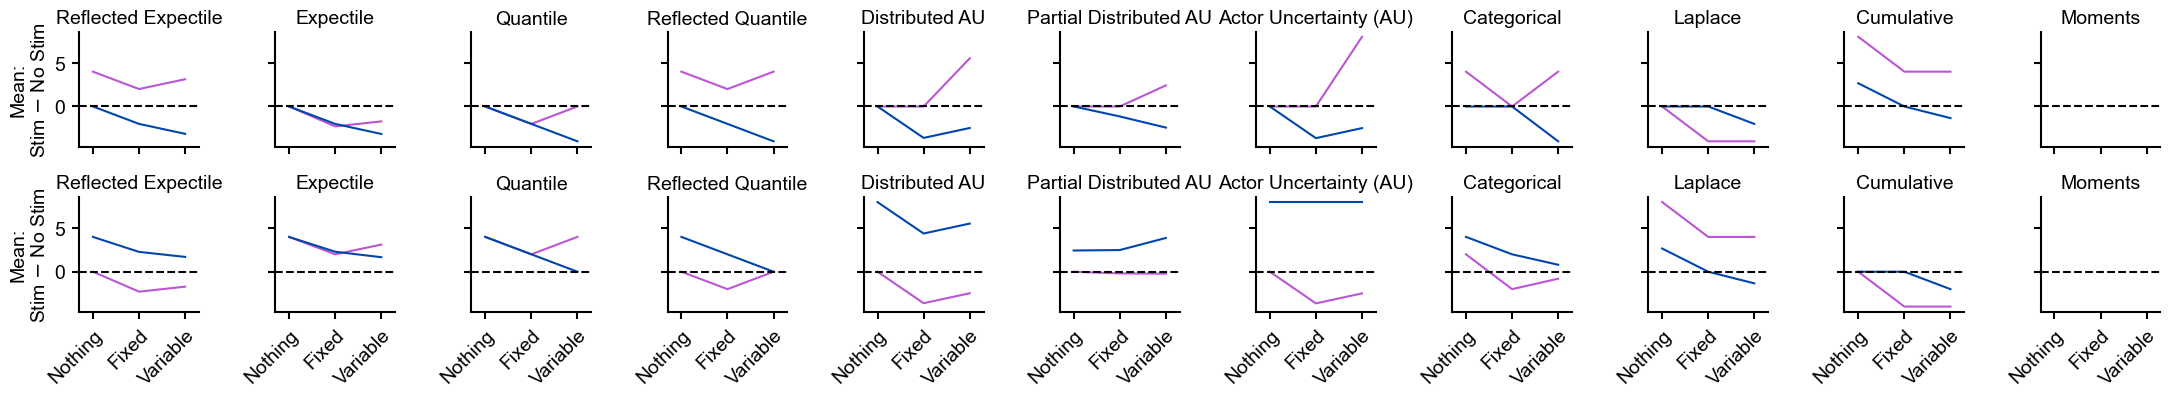

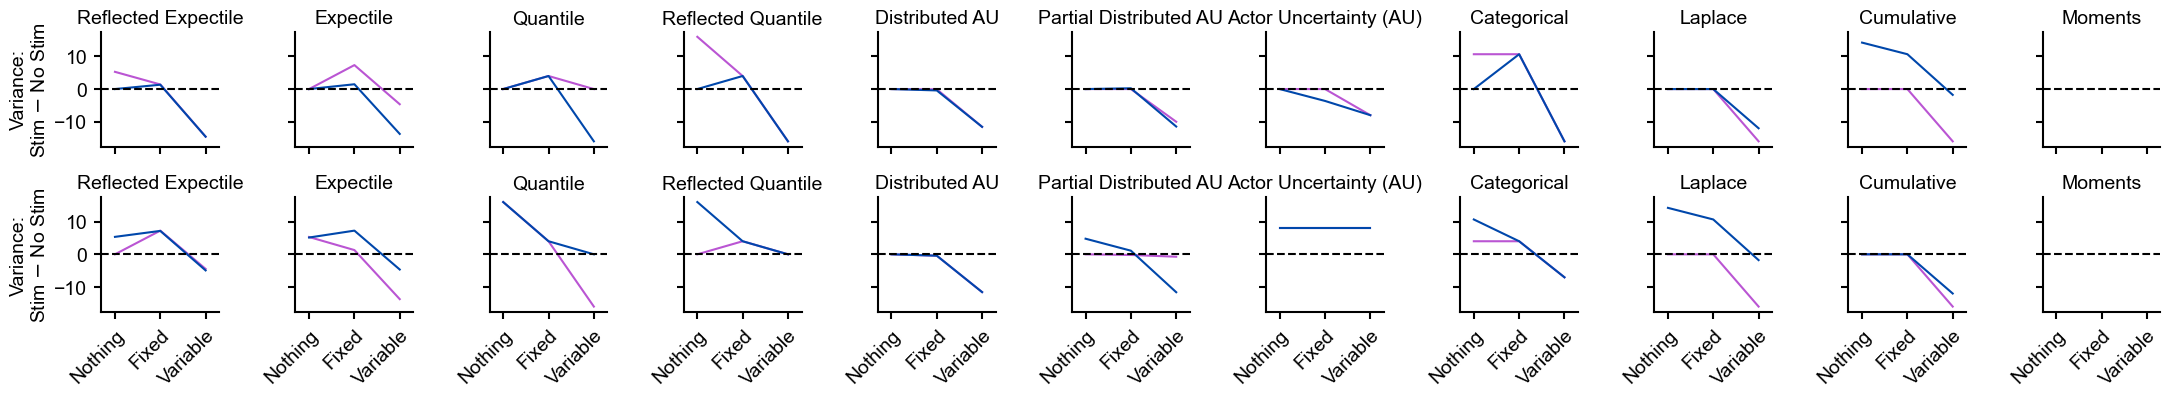

In [21]:
df_list, code_order, info, reduced_activities, all_dists, all_rda = generate_model_predictions(protocol_info, colors, cat=True, plot_detail=True)

In [24]:
rel_nostim_dfs = []
for use_df, sup in zip(df_list, code_order):
    use_df['Model'] = sup
    df_rel_nostim = use_df.copy()
    nostim_value = np.repeat(df_rel_nostim.loc[df_rel_nostim['Manipulation'] == 'No Stimulation', 'Mean'], 3).values
    nostim_variance = np.repeat(df_rel_nostim.loc[df_rel_nostim['Manipulation'] == 'No Stimulation', 'Variance'], 3).values
    df_rel_nostim['Mean'] -= nostim_value
    df_rel_nostim['Variance'] -= nostim_variance
    df_rel_nostim = df_rel_nostim[df_rel_nostim['Manipulation'] != 'No Stimulation']
    df_rel_nostim['excitation'] =  df_rel_nostim['Manipulation']
    df_rel_nostim.loc[df_rel_nostim['excitation'] == 'Excitation', 'excitation'] = True
    df_rel_nostim.loc[df_rel_nostim['excitation'] == 'Inhibition', 'excitation'] = False
    rel_nostim_dfs.append(df_rel_nostim)

In [27]:
corr_dict = {'R2': [],
             'Correlation coefficient': [],
             'model': [],
             'row': [],
             'col_vals': []}

rng = np.random.default_rng(seed=1)
perm_mice = rng.permutation(all_mice)

session_avg_df_rel_nostim['Tail'] = 'Optimistic'
session_avg_df_rel_nostim.loc[session_avg_df_rel_nostim['loc_labels'] == 'Ventral', 'Tail'] = 'Pessimistic'

mouse_avg_df_rel_nostim = session_avg_df_rel_nostim.groupby(
    ['name', 'genotype', 'geno', 'excitation', 'trial_type', 'Distribution', 'stim_trial', 'stim_loc', 'loc_labels']).mean().reset_index()
mouse_avg_df_rel_nostim['dummy'] = dummy_val

geno_df = mouse_avg_df_rel_nostim.copy()  # groupby(['geno', 'excitation', 'Distribution', 'loc_labels'], as_index=False).mean()
geno_df['Tail'] = 'Optimistic'
geno_df.loc[geno_df['geno'] == 'A2a-Cre', 'Tail'] = 'Pessimistic'

mouse_dv_df = mouse_avg_df_rel_nostim.copy()  # groupby(['geno', 'excitation', 'Distribution', 'loc_labels'], as_index=False).mean()
mouse_dv_df['Tail'] = 'Optimistic'
mouse_dv_df.loc[mouse_dv_df['loc_labels'] == 'Ventral', 'Tail'] = 'Pessimistic'

for use_df, sup in zip(rel_nostim_dfs, code_order):
    print(sup)
    
    for df, use_key, use_values in zip([geno_df, mouse_dv_df], ['loc_labels', 'geno'], [trim_loc_labels, genotypes]):
        
        grouped_df = df.groupby(['excitation', 'Tail', 'Distribution', 'loc_labels', 'geno'], as_index=False).mean()
        merged_df = grouped_df.merge(use_df, how='left', on=['Tail', 'Distribution', 'excitation'])
        
        target_df = merged_df
                    
        for i_val, use_value in enumerate(use_values):

            r2s = []
            for excit in excitations:  # fit separate regressions for inhib and excit
                
                inds = np.logical_and(target_df[use_key] == use_value, target_df['excitation'] == excit)
                X = target_df.loc[inds, 'Mean']
                y = target_df.loc[inds, 'licks']
                reg = LinearRegression(fit_intercept=False).fit(X.values.reshape(-1, 1), y)
                r2s.append(reg.score(X.values.reshape(-1, 1), y))    
                
            key_inds = target_df[use_key] == use_value
            X = target_df.loc[key_inds, 'Mean']
            y = target_df.loc[key_inds, 'licks']
            corr_dict['Correlation coefficient'].append(stats.linregress(X, y)[2])
            corr_dict['R2'].append(np.mean(r2s))
            corr_dict['model'].append(sup)
            corr_dict['row'].append(use_key)
            corr_dict['col_vals'].append(i_val)

Reflected Expectile
Expectile
Quantile
Reflected Quantile
Distributed AU
Partial Distributed AU
Actor Uncertainty (AU)
Categorical
Laplace
Cumulative


## Fig. 5g

meta NOT subset; don't know how to subset; dropped


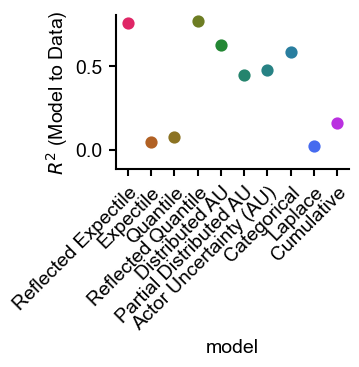

In [30]:
# top right is Ventral, with D1 = optimistic and D2 = pessimistic
model_palette = sns.husl_palette(len(code_order), l=.5, h=1)
# for i, cdict in enumerate([corr_dict]):
#     corr_df = pd.DataFrame(cdict)
#     g = sns.catplot(data=corr_df, x='model', y='R2', hue='model', row='row', col='col_vals', kind='point',
#                     height=3, aspect=1.2, sharey=False, palette=model_palette).set_titles('{row_name}')

#     g.set_xticklabels(code_order[:-1], rotation=45, ha='right', rotation_mode='anchor')
#     g.set_ylabels('$R^2$ (Model to Data)')
#     hide_spines()
#     plt.savefig('./figs/{}_model_data_comparison_{}.pdf'.format(protocol, i), bbox_inches='tight')
    
plt.figure()
ax = sns.pointplot(data=corr_df[np.logical_and(corr_df['row'] == 'loc_labels', corr_df['col_vals'] == 0)],
             x='model', y='R2', hue='model', palette=model_palette)

ax.set_xticklabels(code_order[:-1], rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('$R^2$ (Model to Data)')
ax.set_ylim([ax.get_ylim()[0]-0.1, ax.get_ylim()[1]])
plt.legend().remove()
hide_spines()
plt.savefig('./figs/{}_model_data_comparison_{}_ventral_across_geno.pdf'.format(protocol, i), bbox_inches='tight')
    

## Fig. 5e-f

/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: 
The sizes list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: 
The sizes list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: 
The sizes list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: 
Th

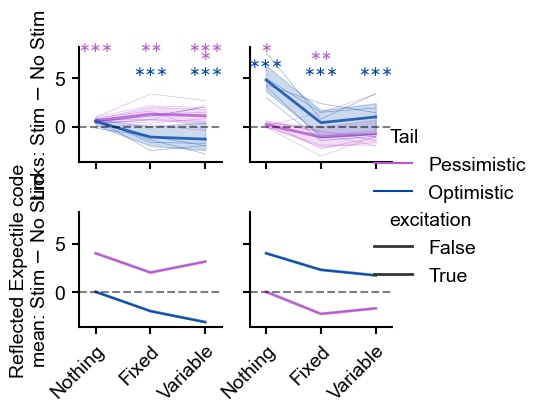

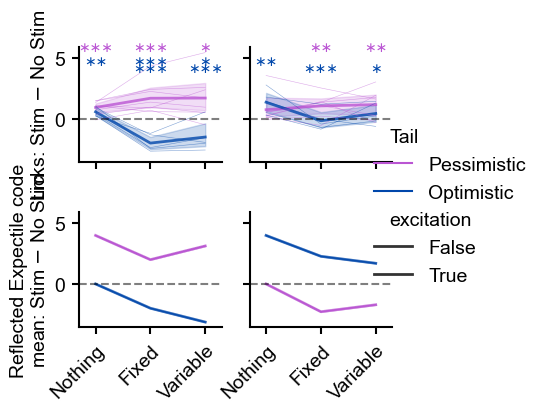

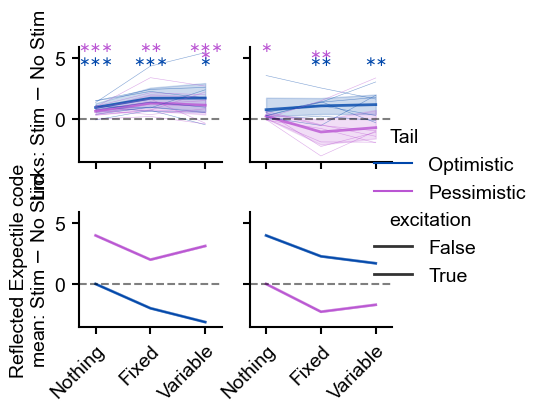

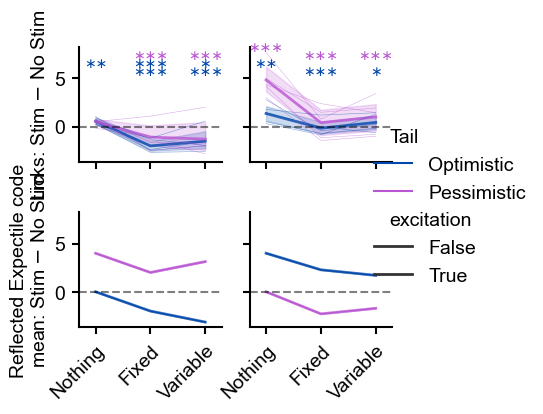

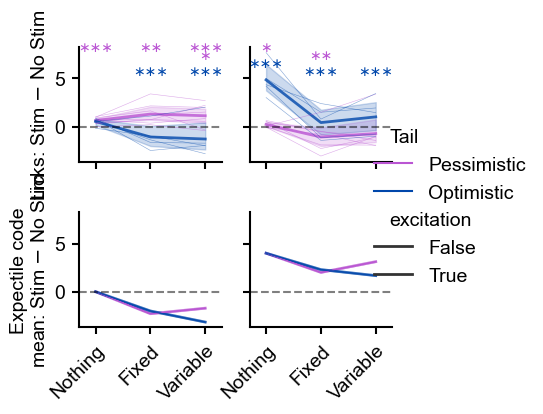

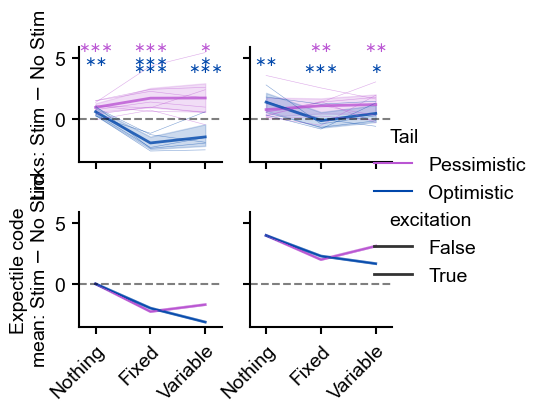

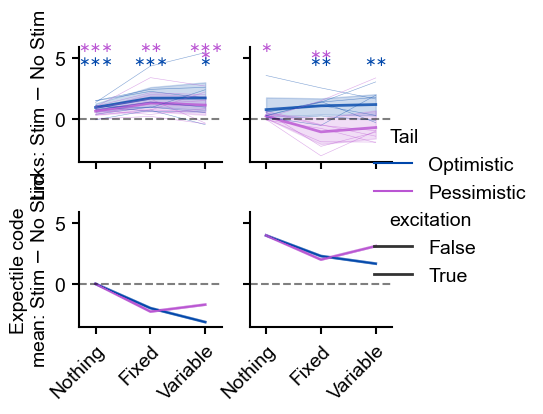

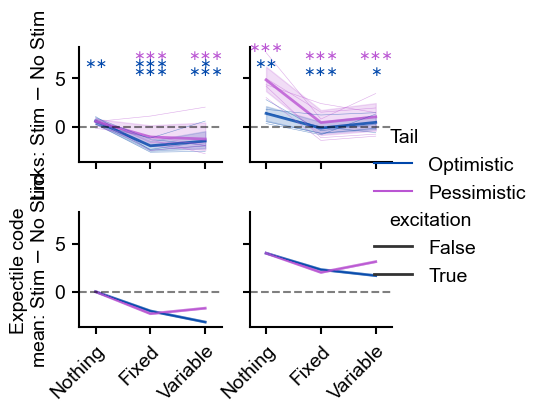

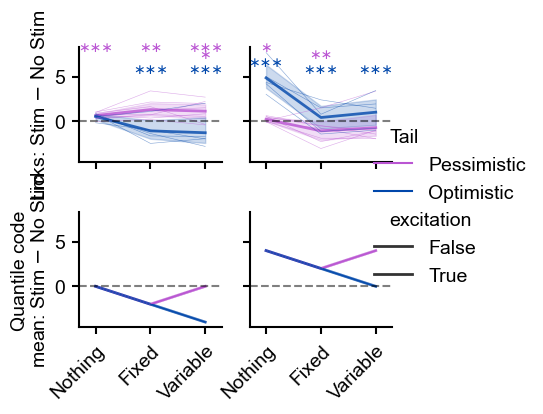

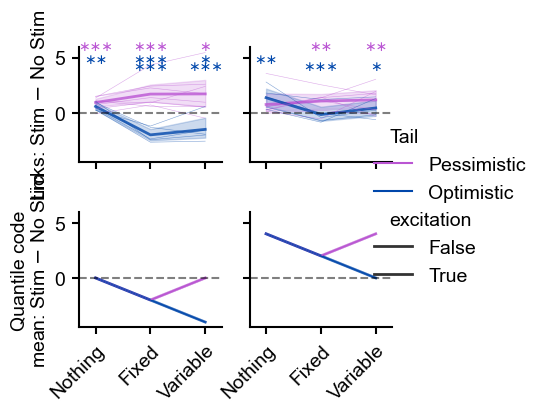

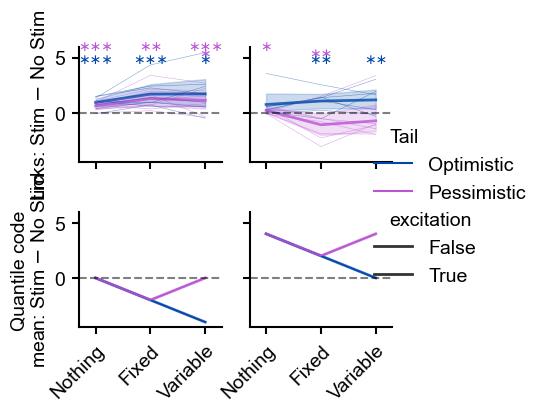

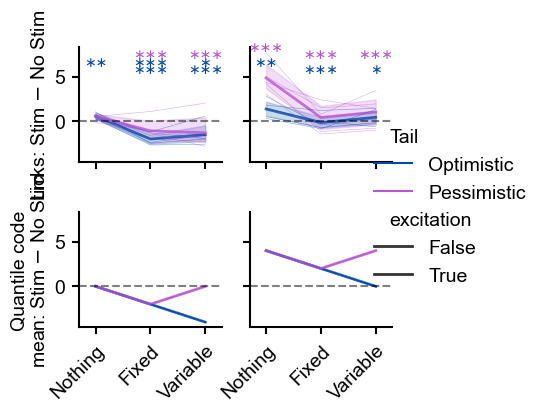

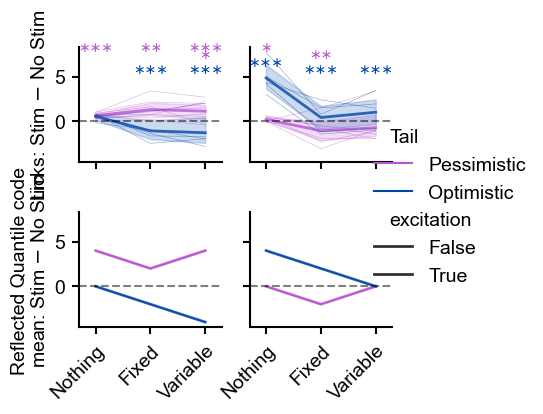

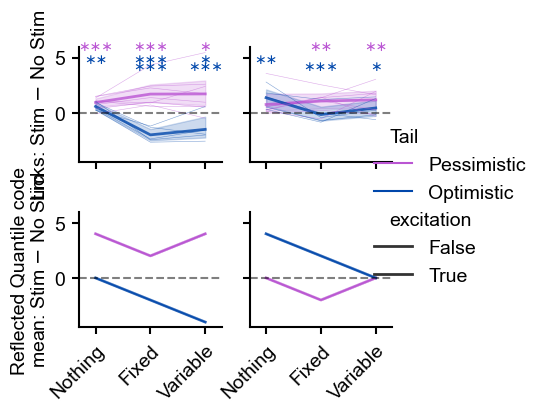

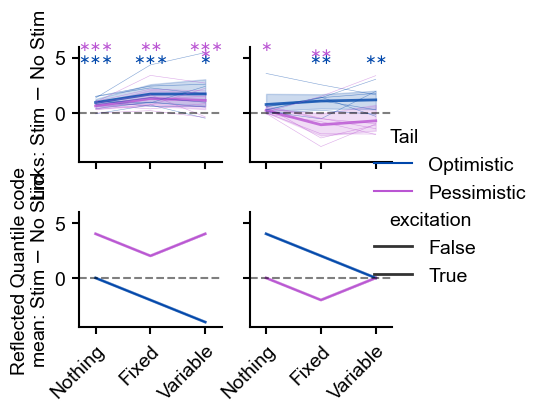

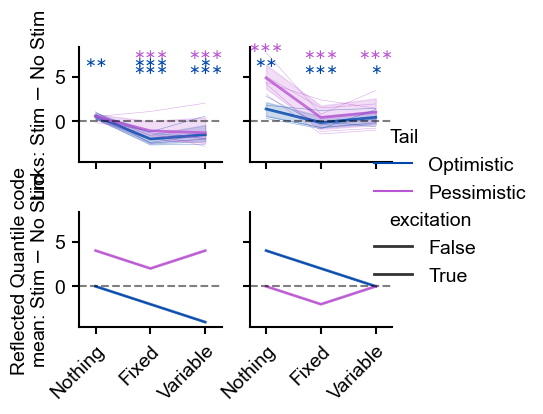

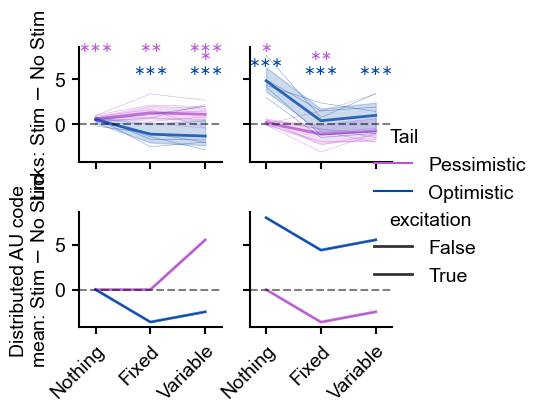

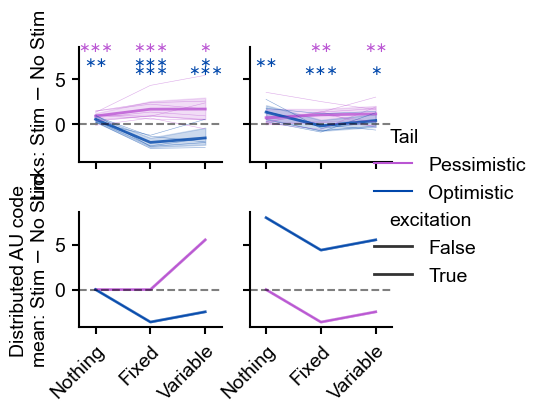

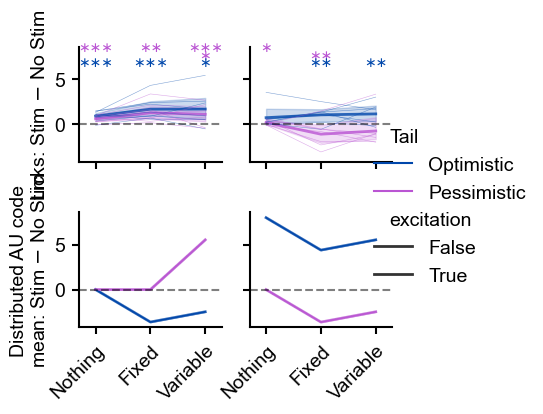

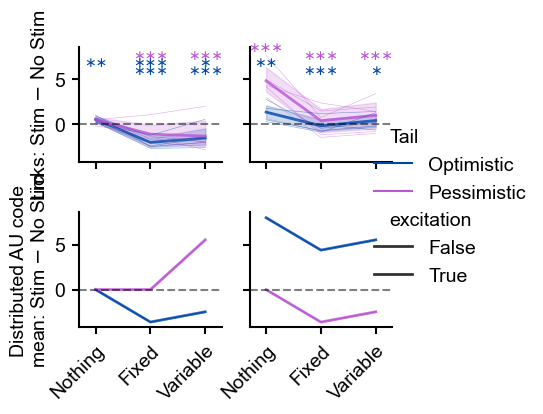

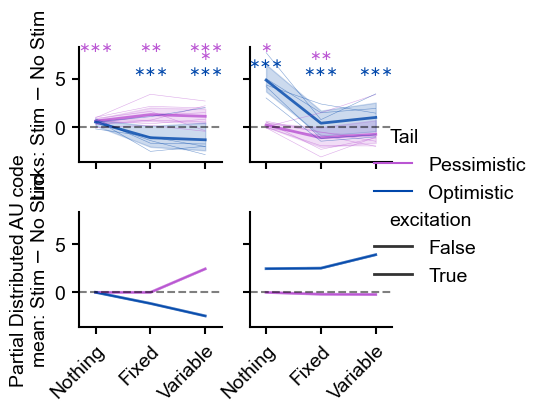

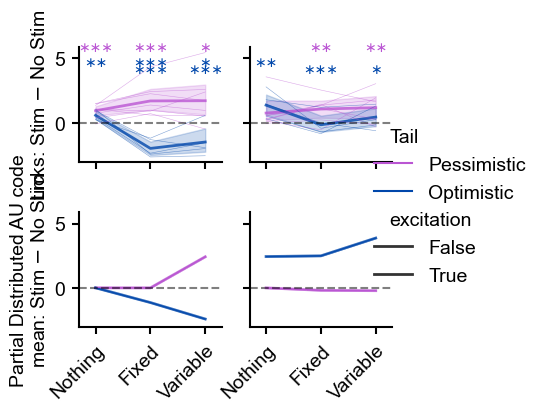

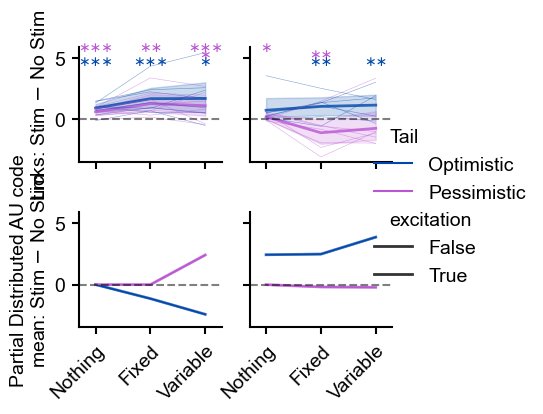

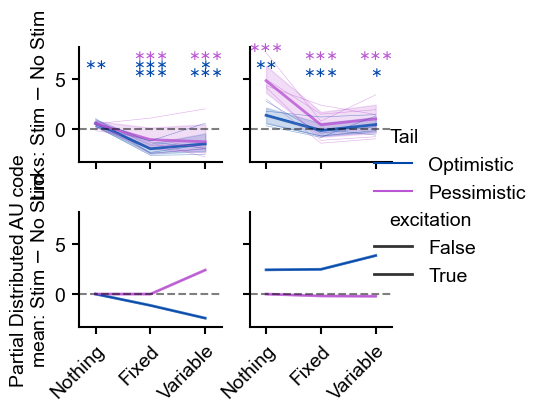

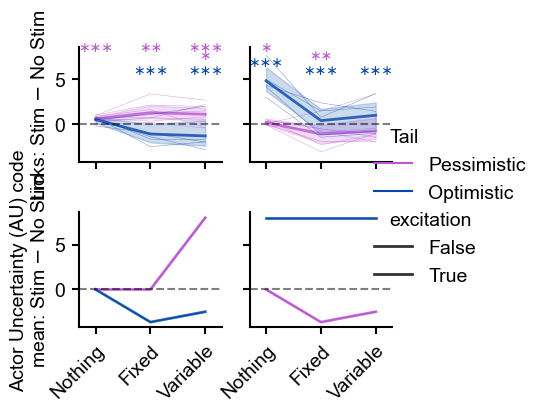

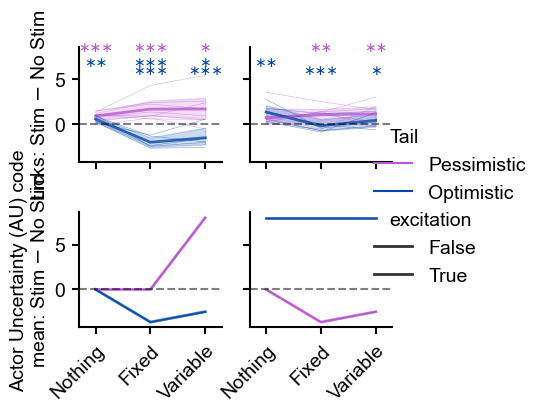

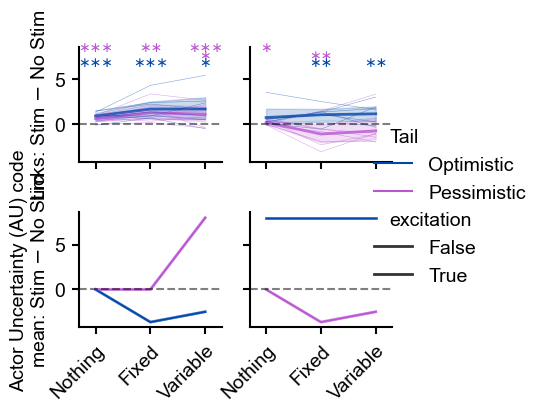

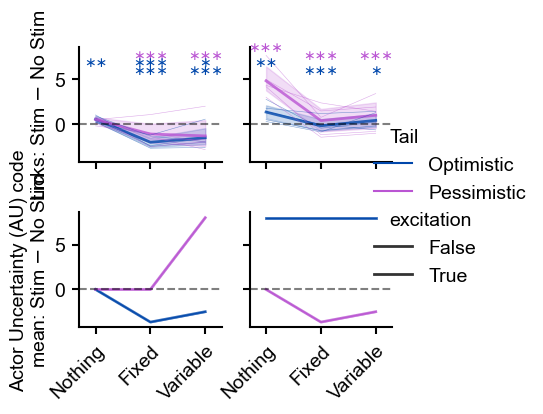

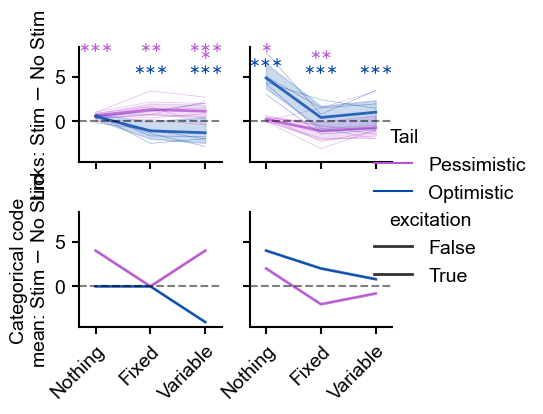

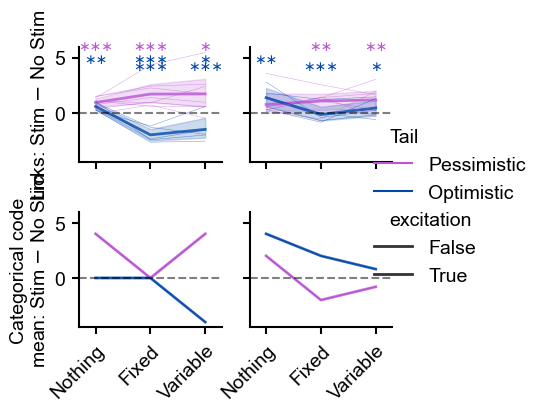

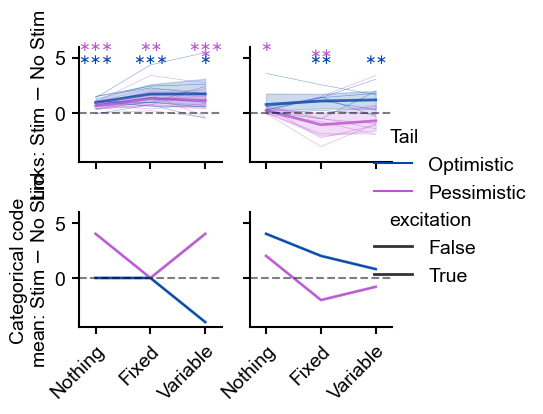

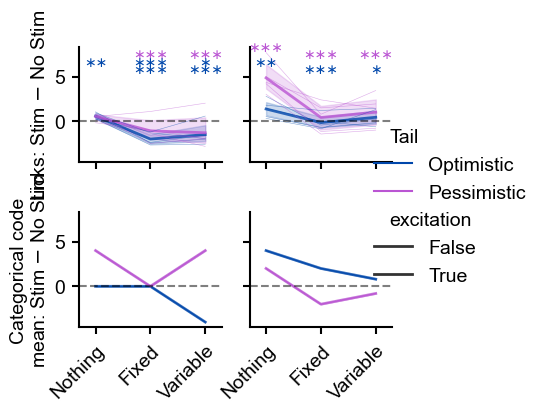

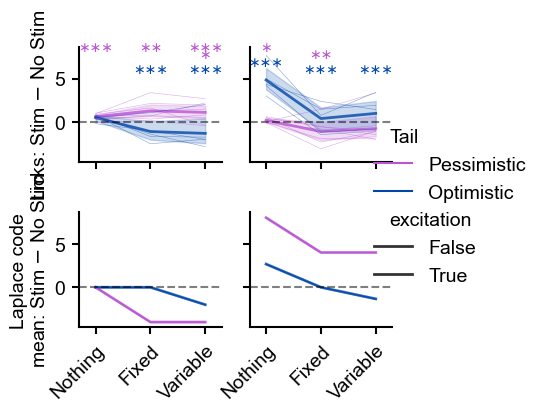

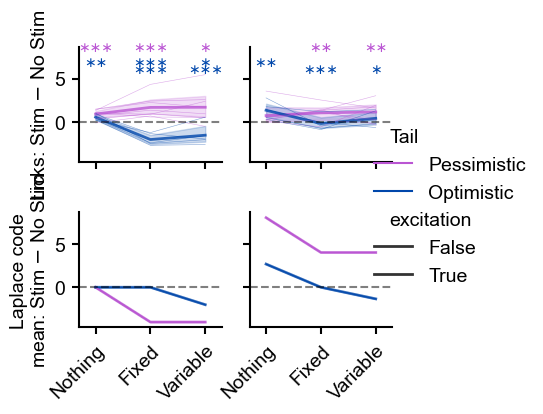

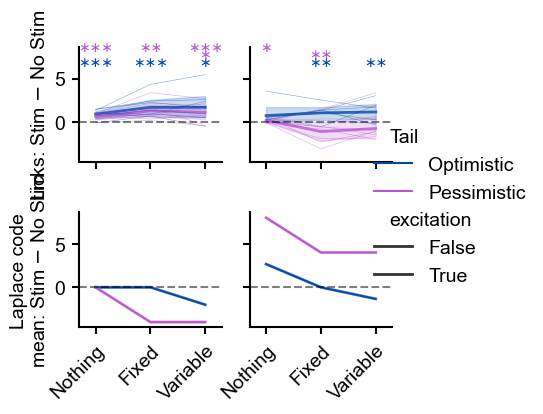

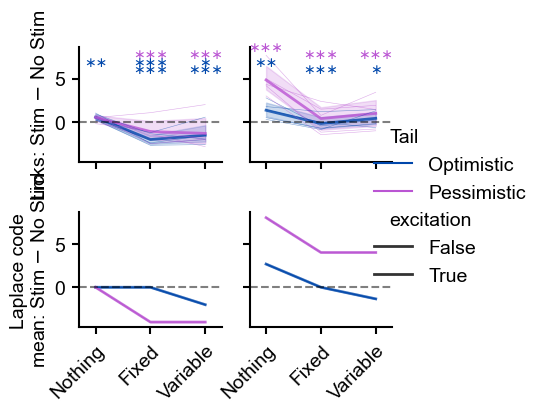

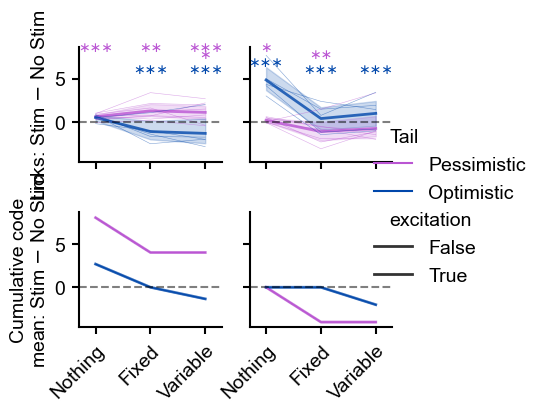

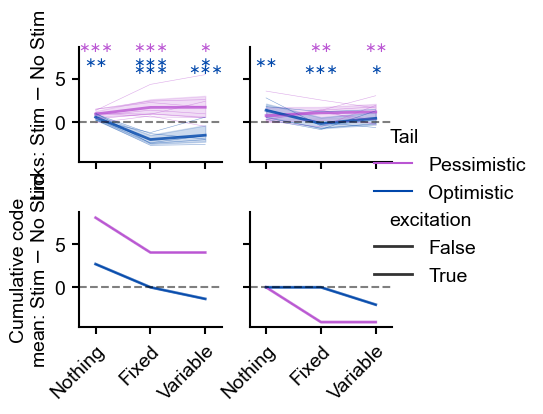

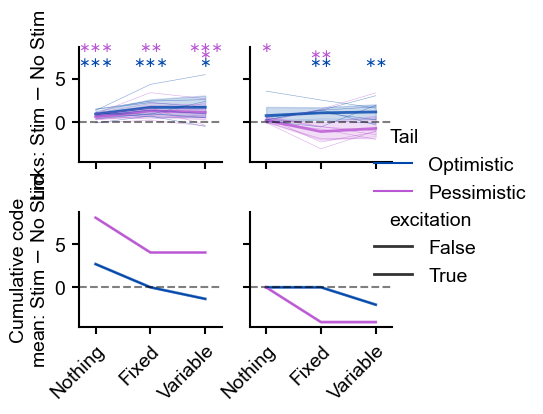

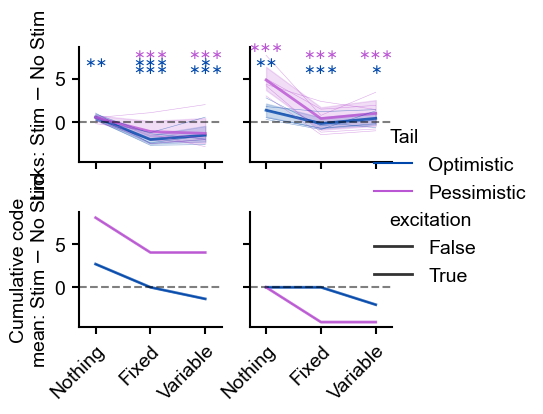

In [31]:
# plot data vs. model predictions, separately for each model (repeating data), so that the grid alignment
# is correct
for use_df, sup in zip(rel_nostim_dfs, code_order):
    
    for df, use_key, use_values, hue_var, tt_ps, use_palette in zip(
        [geno_df, mouse_dv_df], ['loc_labels', 'geno'], [trim_loc_labels, genotypes], ['geno', 'loc'], 
        [tt_genops, tt_locps], [geno_palette, loc_palette]):
        
        for use_value in use_values:
            
            trim_df = df[df[use_key] == use_value]
            grouped_df = trim_df.groupby(['name', 'excitation', 'Tail', 'Distribution', 'loc_labels', 'geno'], as_index=False).mean()
            merged_df = grouped_df.merge(use_df, how='left', on=['Tail', 'Distribution', 'excitation'])

            melt_df = merged_df.melt(id_vars=['name', 'excitation', 'Tail', 'Distribution', 'loc_labels', 'geno', 'trial_type'],
                             value_vars=['licks', 'Mean'], var_name='measure', value_name='diff')

            g = sns.relplot(data=melt_df, row='measure', col='excitation', x='trial_type', y='diff', hue='Tail', 
                            palette=opt_palette, estimator='mean', kind='line', size='excitation', 
                            sizes=[2], alpha=.8, height=2, aspect=.6)
            g.add_legend()
            g.map_dataframe(sns.lineplot, x='trial_type', y='diff', hue='Tail', size='excitation', units='name',
                            palette=opt_palette, sizes=[.4], alpha=.5, estimator=None)

            sns.move_legend(g, (1.2, 0))
            g.refline(y=0,c='k', ls='--', alpha=.5)
        #     g.set_titles('Excitation = {col_name} {row_name}')
            g.set_titles('')
            g.set(xticks=np.arange(protocol_info['n_trace_types']))
            g.set_xticklabels(protocol_info['trace_type_names'], rotation=45, ha='right', rotation_mode='anchor')
            g.set(xlim=(-0.3, 2.3))
            g.set_xlabels('')
            g.axes[0, 0].set_ylabel('Licks: Stim $-$ No Stim')
            g.axes[1, 0].set_ylabel(f'{sup} code\nmean: Stim $-$ No Stim')
            
            for i_col, col in enumerate(excitations):
                ax = g.axes[0, i_col]
                for hue, ytop in zip(use_palette.keys(), [.95, .75]):
                    if hue_var == 'geno':
                        geno = hue
                        lab = use_value
                    else:
                        geno = use_value
                        lab = hue
                        
                    plot_stars(ax, np.arange(protocol_info['n_trace_types']), intps[col][geno][lab],
                               ytop_scale=ytop, star_color=use_palette[hue])
                    plot_stars(ax, np.arange(1, protocol_info['n_trace_types']), ttps[col][geno][lab],
                               ytop_scale=ytop-.1, star_color=use_palette[hue])
            
            fname = f'figs/model_data_comparison_{sup}_{use_value}_by_{hue_var}'
            plt.savefig(fname + '.pdf', bbox_inches='tight')
